# Логистическая модель

[Онлайн-отчет образца данных](http://stireac.com/uskor/result/sherdim%40gmail.com/10.132.32.111__6158019760000190311)



In [1]:
%pylab inline
from ipywidgets import interact

import pandas as pd
from scipy import optimize, special, stats

Populating the interactive namespace from numpy and matplotlib


Загрузим маркеры и извлечем данные для первого этапа.

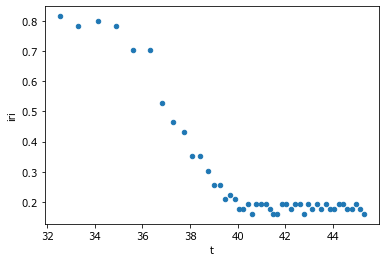

In [2]:
u='http://uskor.stireac.com/result.tsv/sherdim%40gmail.com/10.132.32.111__6158019760000190311'
u = 'm__10.132.32.111__6158019760000190311.tsv'
M = pd.read_table(u)

coab, coad = 1001, 13
tab = M.t[M.v==coab].iloc[0]
tad = M.t[(M.t>tab) & (M.v==coad)].iloc[0]
R = M[(M.t>=tab)&(M.t<tad)].copy()
# оставим только клавиши - код < 100
R = R[(R.v<100) & (R.v>50)]
R['iri'] = R.t.diff()
R.plot('t','iri', kind='scatter');

**Задача** - найти момент перехода от "состояния 0.8" в "состояние 0.2".

**Первый способ** - наивный: задать порог как середину между "большими" и "маленькими" значениями. 

Как порог пересечет, так и новое состояние.

In [3]:
# "Умный" способ определить порог как середину между минимумом и максимумом
vbig = R.iri.max()  #0.8
vsmall = R.iri.min()  #0.2
porog = vsmall + (vbig - vsmall)/2#0.5

i = (R.iri < porog).idxmax()
i

71

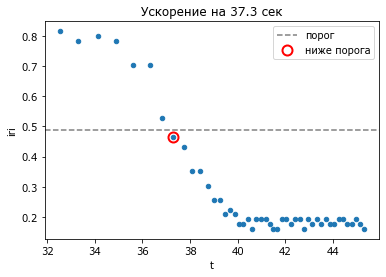

In [4]:
R.plot('t','iri', kind='scatter');
axhline(porog, ls='--', color='gray', label='порог')
plot(R.loc[i].t, R.loc[i].iri, 'o', markersize=10, mew=2, mec='red', mfc=(0,0,0,0), label='ниже порога')
title('Ускорение на {:.1f} сек'.format(R.loc[i].t))
legend();

А если значения сильно "прыгают" вверх-вниз?

Можно применить сглаживание сигнала, например, с помощью скользящего среднего.

## Логистическая кривая

Переход между двумя состояниями хорошо бы смоделировать плавной кривой, которая сначала 1, а потом 0. В точке, где кривая будет проходить через 0.5, будет момент перехода.

Так как мы хотим плавные переходы, то основываемся на экспоненте. Экспонента известна своим стремительным ростом, а нам надо за пределы 1 не выходить.
Чтобы при увеличении экспоненты мы приближались к нулю, перенесем экспоненту в знаменатель $y = \frac{1}{e^t}$. Там, где время равно 0, экспонента равна 1. Зная это, мы в этом месте зафиксируем функцию на уровне 0.5 или $\frac{1}{2}$. Для этого в знаменатель прибавим 1!

$$y = \frac{1}{1+e^t}$$

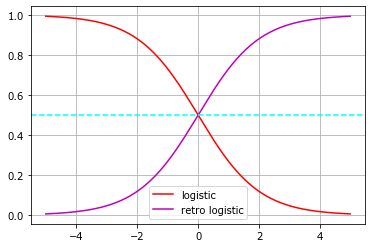

In [5]:
t = arange(-5,5,.01)
y = 1/(1 + exp(t))
y_ = 1/(1 + exp(-t))
plot(t, y, 'r-', label='logistic');
plot(t, y_, 'm-', label='retro logistic');
axhline(0.5, ls='--', color='aqua')
grid(True)
legend();

Если пустить время вспять - то есть используем экспоненциальный спад вместо экспоненциального роста, то получим "отражение" кривой относительно нулевого момента.

Чтобы кривая "двигалась" вдоль оси абсцисс, мы должны добавить в уравнение изменяемый параметр - сдвиг относительно нулевого момента $t_0$, который мы и хотим найти.

$$y = \frac{1}{1+e^{(t - t_0)}}$$

[Логистическое уравнение](https://ru.wikipedia.org/wiki/Логистическое_уравнение) впервые ввел в обиход бельгийский математик Ферхюльст (Pierre François Verhulst) в 1845 году, который занимался моделированием численности населения. Пьер Франсуа писал по-французски, поэтому произносил название функции как "фонксьОн ложистИк".

Для решения уравнения надо выразить $t_0$ через $y$, который нам известен, ведь это и есть наши данные.

$$e^{(t - t_0)} = \frac{1}{y} - 1$$

$$(t - t_0) = log\big(\frac{1}{y} - 1\big)$$

$$t_0 = t - log\big(\frac{1}{y} - 1\big)$$

**Второй способ** - прокрастинация данных из логистической модели в линейную.

Растянем значения между 0 и 1.

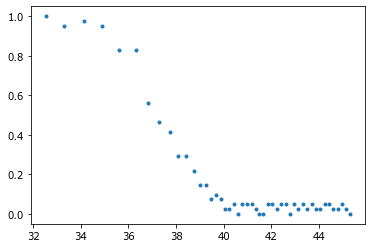

In [6]:
vbig = R.iri.max()  #0.8
vsmall = R.iri.min()  #0.2

t = R.t.values
y = (R.iri.values - vsmall) / (vbig - vsmall)

plot(t, y, '.');

Так как аргументом логарифмической функции должно быть положительное число, то загоним значения в коридор между 0.01 и 1 и преобразуем в линейную зависимость.

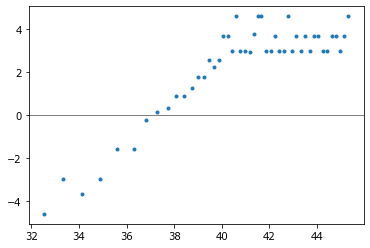

In [7]:
y = np.clip(y, 0.01, 0.99)
ylin = log(1/y - 1)
plot(t, ylin, '.');
axhline(0, lw=1, color='gray');

Точечки выстроились в линию и мы можем найти точку пересечения с осью абсцисс. Числа после 40 с не очень вписываются в зависимость, их мы брать не будем.

In [8]:
bb = (t < 40.5) & isfinite(ylin)
t = t[bb]
ylin = ylin[bb]

Решением линейного уравнения будут такие коэффициенты $a$ и $b$, при которых 
$$\hat{y} = ax + b$$ будет максимально близко к $y$, т.е. $\hat{y} - y$ будут минимальными.

Вариант 1. Ручное решение перемножением матриц.

$$\hat{y} = x \cdot a + 1 \cdot b = [x, 1] \cdot [a, b] = X \cdot ab $$
$$ ab \sim y X^{-1}$$ 

In [9]:
X = vstack([t, ones(shape(t))]).T
X

array([[32.531,  1.   ],
       [33.315,  1.   ],
       [34.115,  1.   ],
       [34.899,  1.   ],
       [35.603,  1.   ],
       [36.307,  1.   ],
       [36.835,  1.   ],
       [37.299,  1.   ],
       [37.731,  1.   ],
       [38.083,  1.   ],
       [38.435,  1.   ],
       [38.739,  1.   ],
       [38.995,  1.   ],
       [39.251,  1.   ],
       [39.459,  1.   ],
       [39.683,  1.   ],
       [39.891,  1.   ],
       [40.067,  1.   ],
       [40.243,  1.   ],
       [40.435,  1.   ]])

In [10]:
ab = ylin.dot(pinv(X).T)
ab

array([  1.01657639, -37.8654124 ])

Вариант 2. Полином 1-й степени.

In [11]:
poly = polyfit(t, ylin, 1)
poly  # Polynomial coefficients

array([  1.01657639, -37.8654124 ])

Вариант 3. Линейная регрессия

In [12]:
res = stats.linregress(t, ylin)
res

LinregressResult(slope=1.0165763888921413, intercept=-37.86541239882311, rvalue=0.9841356925993816, pvalue=5.707543579625907e-15, stderr=0.04319614854900949, intercept_stderr=1.6271761689596071)

Вариант 4. OLS (ordinary least squares) model

In [13]:
import statsmodels.api as sm
mo = sm.OLS(ylin, sm.add_constant(t)).fit()
mo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     553.8
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           5.71e-15
Time:                        05:24:55   Log-Likelihood:                -11.571
No. Observations:                  20   AIC:                             27.14
Df Residuals:                      18   BIC:                             29.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.8654      1.627    -23.271      0.000     -41.284     -34.447
x1             1.0166      0.043     23.534      0.000       0.926       1.107
==============================================================================
Omnibus:                        3.275   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.194   Jarque-Bera (JB):                2.086
Skew:                           0.791   Prob(JB):                        0.352
Kurtosis:                       3.054   Cond. No.                         603.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
mo.params

array([-37.8654124 ,   1.01657639])

Сравните названия, которыми в разных вариантах обозначаются полученные значения.

Обратите внимание, что в двух последних вариантах мы получаем оценку точности полученных значений (stderr).

Наше решение там, где прямая проходит через ось абсцисс. Решаем уравнение.

$$ ax + b = 0 $$

$$ x = - b/a $$

In [15]:
a, b  = ab

t0 = -b/a
t0

37.247975471955044

Так как мы получили оценки точности, то можем посчитать минимальное и максимальное возможные решения с учетом погрешности.

In [16]:
b, a = mo.params
berr, aerr = mo.bse
berr, aerr

(1.6271761689595965, 0.0431961485490092)

In [17]:
t0 = -b/a
t0min = -(b-berr)/(a-aerr)
t0max = -(b+berr)/(a+aerr)
t0min, t0max

(40.57262201445649, 34.19435298574704)

Визуально наложим решение поверх данных.

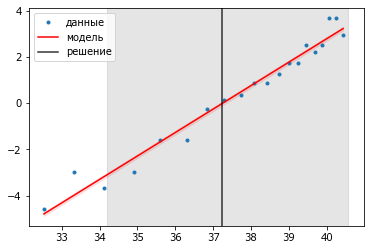

In [18]:
plot(t, ylin, '.', label='данные');
xx = np.linspace(t[0],t[-1],100)
yy = a*xx + b
plot(xx,yy, 'r', label='модель')
y_std = aerr
k = 2
fill_between(xx, yy - k*y_std, yy + k*y_std, alpha=0.1, color='r')

axvspan(t0min, t0max, color='k', alpha=0.1)
axvline(t0, color='k', alpha=0.8, label='решение')

legend();

А теперь изобразим модель после преобразования в исходную логистическую зависимость. 

Не забываем выполнить депрокрастинацию.

$$y' = (y - v_{small}) / (v_{big} - v_{small})$$

$$y = y' (v_{big} - v_{small}) + v_{small}$$

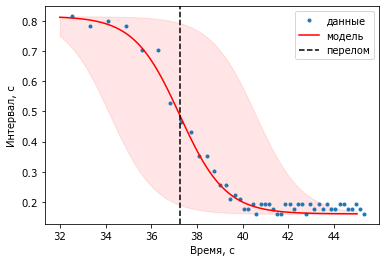

In [19]:
plot(R.t, R.iri, '.', label='данные');
xx = np.linspace(32,45,100)

# для оригинальной модели нам не нужны a и b - только один параметр t0 !
yyori = 1/(1+exp(xx - t0))
yyori = yyori*(vbig - vsmall) + vsmall
plot(xx, yyori, 'r', label='модель')

yyorimax = 1/(1+exp(xx - t0max)) *(vbig - vsmall) + vsmall
yyorimin = 1/(1+exp(xx - t0min)) *(vbig - vsmall) + vsmall
fill_between(xx, yyorimin, yyorimax, alpha=0.1, color='r')

axvline(t0, ls='--', color='k', label='перелом')
xlabel('Время, с')
ylabel('Интервал, с')
legend();

**Третий способ** - подбор параметров модели.

В полной [логистической модели](https://en.wikipedia.org/wiki/Logistic_function), предполагающей два устойчивых состояния, можно задать четыре параметра.


$$y(x) = { u-d \over 1+e^{-k(x-x_0)} } + d$$

Сделав такую функцию, подборем ее параметры с помощью метода оптимзации `curve_fit` (подгонка кривой).

In [20]:
def func(x, u, d, x0, k):
    '''Логистическа функция с 4 параметрами
    
    x - данные для преобразования
    u - "верхняя полка"
    d - "нижняя полка"
    x0 - время "прыжка"
    k - крутизна "прыжка"
    
    https://en.wikipedia.org/wiki/Logistic_function'''
    return ((u-d) / (1+( np.exp(-k*(x-x0))))) + d

# данные для подбора
x, y = R.loc[R.iri.notnull(), ['t','iri']].values.T
# x = x - x[0]

popt, pcov = optimize.curve_fit(func, x, y, method='dogbox',
                 p0=[ max(y), min(y), x[-1], .1],
                 bounds=([0, min(y), min(x), -1e8],
                         [max(y), max(y), max(x),  1e8]),
                 #maxfev=5000  
                )
popt

array([ 0.81195291,  0.17677216, 37.27717735, -1.11004777])

Мы получили четыре искомых параметра. Теперь визуализируем результаты. Для генерации модельных значений будем использовать ту же функцию, но для значений х, плавно изменяющихся от минимума к максимуму.

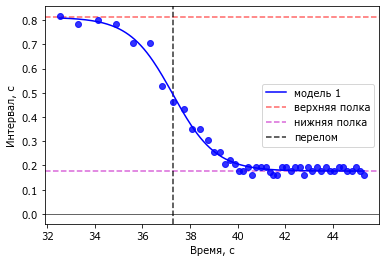

In [21]:
co = 'b'
label = 'модель 1'

#def plot_model(x,y, popt, co, label):
#    '''Функция для рисования данных и модели одним цветом'''
plot(x, y, marker='o', lw=0, color=co, alpha=.8, zorder=3)

xx = linspace(x.min(), x.max(), 200)
yy = func(xx, *popt)
plot(xx,yy, color=co, ls='-', label=label, zorder=10);

axhline(popt[0], color='r', ls='--', alpha=.6, label='верхняя полка')
axhline(popt[1], color='m', ls='--', alpha=.6, label='нижняя полка')
axvline(popt[2], color='k', ls='--', alpha=.8, label='перелом')

axhline(0, color='k', ls='-', lw=1, alpha=.6)

ylabel('Интервал, с')
xlabel('Время, с');
legend();


Для наложения нескольких рисунков один поверх другого удобно иметь в распоряжении функцию, параметрами которой будут данные и параметры отображения - цвет и подпись.
При повторном вызове функции можно получить сложный разноцветный рисунок.

Чтобы получить из предыдущего фрагмента кода функцию:
1. Раскомментируйте строку определения функции и ее описания
2. Сдвиньте весь нижележащий код вправо на 4 пробела.

In [22]:
#plot_model(x,y, popt, co, label)
#plot_model(x+2,y+0.1, popt+[.1,.1,2,0], 'orange', 'другой процесс')
#plot_model(x+3,y-0.1, popt+[-.1,-.1,3,0], 'green', 'совсем другой процесс')